# Relax Inc. Take-Home Challenge

In this assignment we will:
1. Load and Explore the data:
    * takehome_user_engagement.csv
    * takehome_users.csv
2. Clean, Transform, and Visualize the data.
3. Identify  which  factors  predict  future  user adoption.
    * Defining an "adopted user" as a user who has logged into the product on 3 separate days in at least one 7-day period.

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc


In [2]:
#Load the user engagement file.
df = pd.read_csv('takehome_user_engagement.csv')
df.time_stamp = pd.to_datetime(df.time_stamp)
df = df.sort_values(by=['user_id', 'time_stamp'])
#We drop the "visited" column because it provides no useful info. It's alway "1" for "True".
df = df.drop('visited', axis=1) 

df.head(3)

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2


In [3]:
# Using the "engagement" df, let's identify which users are "adopted" users, defined as:
# a user who has logged into the product on 3 separate days in at least one 7-day period.

# Drop users who do not have more than 3 visits.
df = df.merge((df.groupby('user_id').nunique().time_stamp >=3), on = 'user_id', how = 'outer')
df = df[df.time_stamp_y == True]
df = df.drop(columns='time_stamp_y')
df = df.rename(columns = {'time_stamp_x':'time_stamp'})


#Find the difference between each timestamp and 2 timestamps ago.
#If the value is less than or equal to 7 days, then that person has logged in 3 times within a 7-day period.

diff = [] #make an empty list
for x in range(len(df)-2):
    if (df.iloc[x+2,1] == df.iloc[x,1]):
        diff_days = df.iloc[x+2,0] - df.iloc[x,0]
        diff.append(diff_days)
    else:
        diff.append(np.nan)

#account for the edge cases at the end of the df.
diff.append(np.nan)
diff.append(np.nan)

#assign the differences to a new column
df['diff'] = diff

#keep only the values where the user signed in 3 times within a 7-day period.
seven_days = pd.Timedelta("7 days")
df = df[df['diff'] <= seven_days]
df['adopted_user'] = True

#drop duplicate user_id's, and drop the time_stamp and diff columns.
df = df.drop_duplicates(subset=['user_id'])
df = df.drop(columns=['time_stamp', 'diff'])
df = df.reset_index(drop=True)

#Now what we have left is essentially a list of adopted users.
print('There are', df.shape[0],'adopted users, or', round(df.shape[0]/120,2),'% of our total number of users.')

There are 1656 adopted users, or 13.8 % of our total number of users.


In [4]:
#save the df under a new name, and set it aside for now.
#(this is so we can use "df" as the name of our next df.
adopted = df

In [5]:
#Load the users information file

df = pd.read_csv('takehome_users.csv', encoding= 'unicode_escape')

df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time*1000000000)

#Let's merge our "adopted" df onto our user info df. 
#Now we have labels for each user, whether they are adopted users or not.

df = df.rename(columns = {'object_id':'user_id'}) #rename column to merge on
df = df.merge(adopted, on='user_id', how='left')

df.head(3)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,NaN


In [6]:
#We have many features that are categorical.

#Create a new column 'days_of_use', that takes the difference between the last_session and the account creation_time.
#Save this as days. This will tell us how long an account has been in use (regardless of frequency).
df['days_of_use'] = (df.last_session_creation_time - df.creation_time)
df['days_of_use'] = (df.days_of_use.to_numpy()/np.timedelta64(1, 'D')).astype(int) #convert to int
df['days_of_use'] = df['days_of_use'].mask(df['days_of_use']<0).fillna(0) #remove values with negative days

#User_id, name, and email are unique to each individual (high cardinality), so we should drop those.
#Also drop creation_time and last_session_creation_time.
df = df.drop(columns=['user_id', 'creation_time', 'name', 'email', 'last_session_creation_time'])

#One-hot encode "creation_source" to make it ML friendly.
one_hot = pd.get_dummies(df['creation_source'])
df = df.drop('creation_source',axis = 1)
df = df.join(one_hot)

#convert invited_by_user_id  into binary values (1 = invited by someone, 0 = no invite)
df = df.fillna(0)
df['invited_by_user_id'] = df['invited_by_user_id'].mask(df['invited_by_user_id']>0).fillna(1)

#convert adopted_user into binary value (True = 1, NaN = 0)
# Note: we already did df.fillna(0) in the previous step, so the NaN is already taken care of.
df['adopted_user'] = df['adopted_user'].astype(int)

#One-hot encode "org_id" to make it ML friendly. 
#Note: this column has 417 unique values, giving it somewhat high cardinality. 
#A good goal for classification models is to have >= 10x rows as columns. Since we have 12000 rows, adding 417 should be OK.
one_hot = pd.get_dummies(df['org_id'])
df = df.drop('org_id',axis = 1)
df = df.join(one_hot)

In [7]:
#Now our dataset is ready for some visualization, train/test split, and then ML modeling.

y = df['adopted_user']
X = df.drop(columns = ['adopted_user'])

#Here we use MinMaxScaler because this way we can preserve the 0/1 binary values for the majority of our features.
#Only the feature "days_of_use" will be affected.
#(On the other hand, if we used StandardScaler, we lose the binary quality of our other features.)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

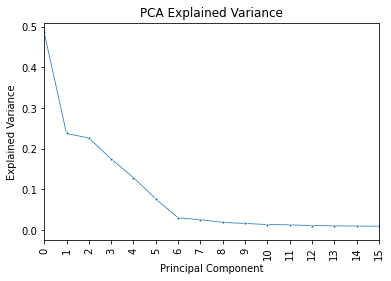

In [8]:
#PCA visualization. How many features explain the variance of our data?

pca = PCA()
pca.fit(X_scaled) #We look at X_scaled here, because X will just show all variation in days_of_use

y_pca = pca.explained_variance_
x_pca = np.arange(len(y_pca))
_=sns.lineplot(x_pca,y_pca, marker='.', size=20, legend=False)
_=plt.ylabel('Explained Variance')
_=plt.xlabel('Principal Component')
_=plt.title('PCA Explained Variance')
_=plt.xticks(np.arange(len(y_pca)), rotation=90)
_=plt.xlim([0, 15]) #truncate after 15, so we can more easily see the elbow point

#the elbow point (subjective) seems to occur around 6. 

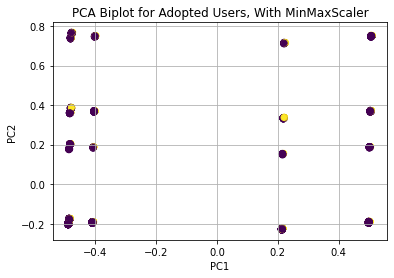

In [10]:
#Below is code to plot a PCA biplot, adapted from the author Serafeim Loukas of the following article:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

pca = PCA()
x_new = pca.fit_transform(X_scaled)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y.to_numpy())
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.title('PCA Biplot for Adopted Users, With MinMaxScaler')
plt.show()

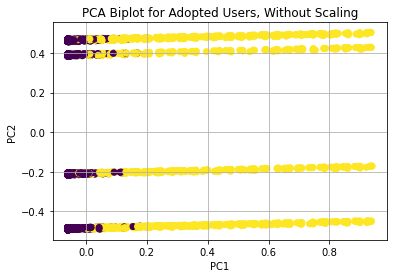

In [11]:
#Do the same thing, but this time with X before it was scaled (i.e. we see variation in days_of_use)
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y.to_numpy())
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.title('PCA Biplot for Adopted Users, Without Scaling')
plt.show()

The first PCA biplot tells us nothing. The second PCA biplot has x-axis labeled PC1, but it must correspond to days_of_use since it's the only feature that has a range greater than [0,1] (actually, [0,729]). Knowing this, it looks like people who have had their accounts longer tend to become adopted users.

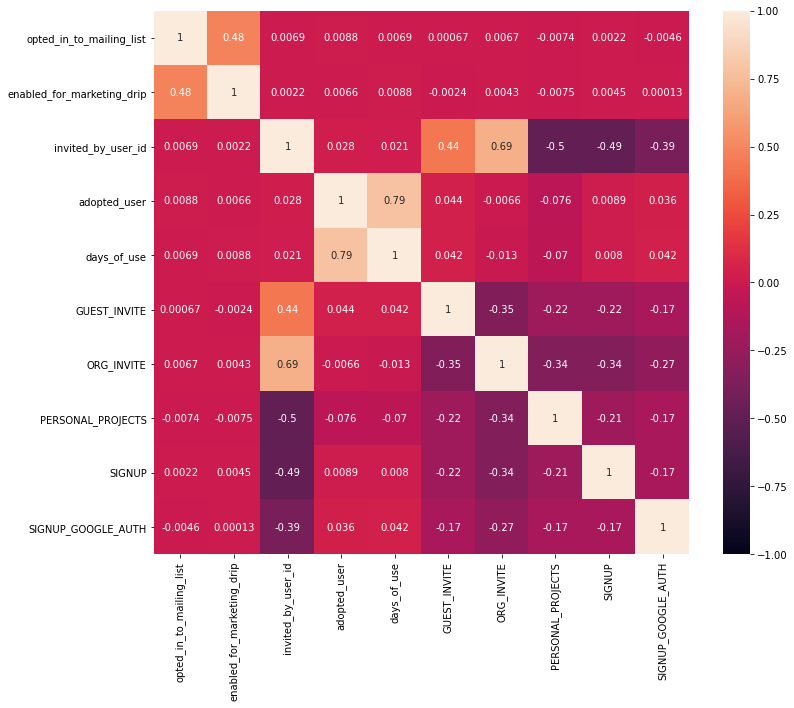

In [12]:
plt.subplots(figsize=(12,10))

#ignore the columns that have to do with org_id (high cardinality)
col_names = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip',
       'invited_by_user_id', 'adopted_user', 'days_of_use', 'GUEST_INVITE',
       'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'] 
sns.heatmap(df[col_names].corr(), vmin = -1, vmax = 1, annot=True,);

Look at adopted_user column. It has a high correlation to days_of_use, supporting our earlier observation from the PCA biplot.

In [13]:
#70/30 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8400, 426), (3600, 426), (8400,), (3600,))

RF Accuracy=0.969
RF F1-score=0.969
RF precision=0.925
RF recall=0.860

Confusion Matrix without Normalization
[[3035   37]
 [  74  454]]

Confusion Matrix with Normalization
[[0.99 0.01]
 [0.14 0.86]]
The top 10 most important features for RF Classifier.


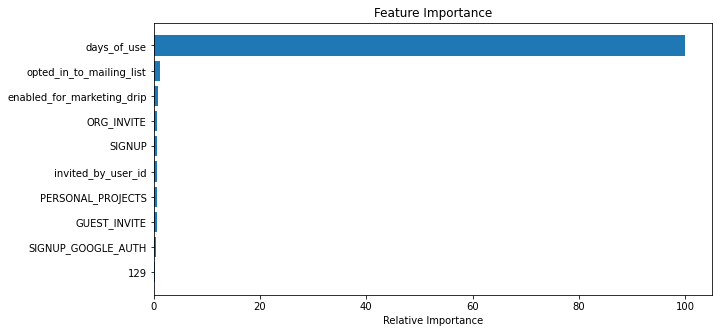

In [18]:
#Model with Random Forest, and plot the feature importance.

#Modeling step:
rf_clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rf_clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('RF Accuracy=%.3f' % (ac))
print('RF F1-score=%.3f' % (f1))
print('RF precision=%.3f' % (pr))
print('RF recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))


#Feature Importance:
feature_importance = rf_clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)[:10]

print('The top',sorted_idx.size,'most important features for RF Classifier.')

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()

plt.show()

# Conclusion

As seen from the heatmap, PCA biplot (without scaling), and RF Model Feature importance, the most important factor in predicting future user adoption is "days_of_use", i.e. the number of days between when the user last logged in and when they first created their account. In other words, __older accounts tend to have more user adoption.__ 

The next few important features after days_of_use are:
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails.
* enabled_for_marketing_drip: whether they are on the regular marketing email drip.
* ORG_INVITE: whether their account was created via being invited to an organization.
* SIGNUP: whether their account was created via signing up through the website.
* invited_by_user_id: whether they were invited by another user.

# Action Items

To increase future user adoption, we can try the following:
* Push to increase mailing list opt in for users (possibly by advertising or prompting them to sign up for the mailing list, lest they "miss out" on some great experiences).
* Push to increase marketing drip enablement for users (similar to the previous recommendation).
* Make business deals with organizations to invite their members to sign up for accounts (increase ORG_INVITE signups).
* Incentivize users to invite other users (create some incentivization program for each invite that results in a new account created).

While the most prominent feature in our model prediction (days_of_use) cannot directly be affected (we cannot force someone to sign on to the platform after a long time of not signing on), we are able to act on this list of action items, which will help us to incrementally increase the number of users who sign up and eventually become adopted users. Next steps can include A/B testing to see what emails/prompts result in higher opt-in rates.